In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

# Load Critic Dataset

In [4]:
def get_crit_data(bs= 32, size=(336, 336)):
    path = "../src/dsin"
 
    kitti_stats = ([0.367, 0.385, 0.372], [0.288, 0.298, 0.301]) # mean, std

    data_image = (ImageList.from_csv(path=path, cols = 'name', csv_name = 'DISC_KITTI_TOT.txt')
                     .split_by_rand_pct(0.1, seed=42)
                     .label_from_df(cols='label')
                     .transform(None, size=size, resize_method=ResizeMethod.CROP)
                     .databunch(bs=bs)
                     .normalize(kitti_stats))
    #     data_image.c = 3
    data_image
    return data_image

In [5]:
# data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

data_crit = get_crit_data(bs = 4)

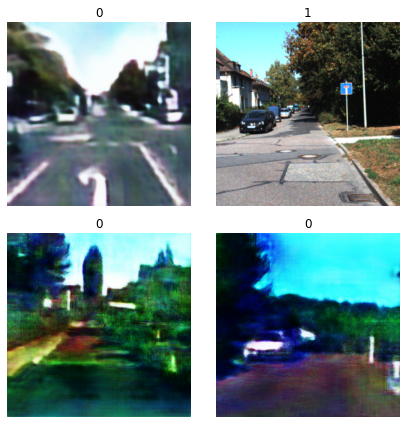

In [6]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [7]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())


# Create Critic

In [8]:
class SiCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = gan_critic()
    def forward(self,*args,**kwargs):
        return self.model(args[0])
        #if len(args) == 1: # assume single image input
        #if len(args) == 6 : # output from si_autoenv with loss variables then 0 position is x_reconstructed
            
            
            
        
    

In [9]:
wd = 1e-3

In [10]:

learn_critic = Learner(data_crit, SiCritic(), metrics=accuracy_thresh_expand, loss_func=loss_critic, wd=wd)

In [11]:
learn_critic.fit_one_cycle(4, 1e-3)


epoch,train_loss,valid_loss,accuracy_thresh_expand,time


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tfastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/tfastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/tfastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/tfastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
input()

In [ ]:
! ls ../src/dsin/models

In [17]:
model_fname = '20200818-critic-pre-gan'
learn_critic.save(model_fname)
!aws s3 cp ~/tDSIN/src/dsin/models/{model_fname}.pth  s3://dsin-us/models/


upload: ../src/dsin/models/20200818-critic-pre-gan.pth to s3://dsin-us/models/20200818-critic-pre-gan.pth


#  METRIC

In [12]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        
        if last_output[0] is None:
            X_OUTPUT = 1 # X_DEC
        else:
            X_OUTPUT = 0 # X_HAT_OUT
        val = self.func(last_output[X_OUTPUT], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()
        
    
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
    
class ParameterMetricCallback(Callback):
    def __init__(self,loss_man):
        self.loss_man = loss_man
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        if hasattr(self.loss_man,'soft_bit_entropy'):
            self.pbar.child.comment += f' soft_bit_entropy: {self.loss_man.soft_bit_entropy:.4f}'

class ParameterRunningAverageMetricCallback(Callback):
    def __init__(self,loss_man,alpha=0.1):
        self.loss_man = loss_man
        self.alpha = alpha
        self.val = None
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        self.importance_map=kwargs["last_output"][3].detach()
#         import pdb
#         pdb.set_trace()
        if hasattr(self.loss_man,'soft_bit_entropy'):
            if self.val is None:
                self.val = self.loss_man.soft_bit_entropy.detach()
            else:
                self.val *= 1 - self.alpha
                self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
                
            self.pbar.child.comment += f' avg_bpp: {self.val / 2 :.4f} imp-mean-var {(torch.mean(self.importance_map),torch.var(self.importance_map))}'
            msg = f"bitcost_loss={self.loss_man.bit_cost_loss_value:.1f} "
            msg += f"l2reg_loss={self.loss_man.l2_reg_loss:.1f} "
            msg += f"autoencoder_loss_value={ self.loss_man.autoencoder_loss_value:.1f} "
            msg += f"si_loss={self.loss_man.si_net_loss_value:.1f} "
            msg += f"feat_loss_value={self.loss_man.feat_loss_value:.1f}"

            self.pbar.child.comment += msg
    

# GAN

In [13]:
learn_critic=None
gc.collect()

8307

In [14]:
data_crit = get_crit_data(bs = 1)
learn_critic =(Learner(data_crit, SiCritic(), metrics=None, loss_func=loss_critic, wd=wd)
               .load('20200818-critic-pre-gan'))


In [15]:

baseae_path = "../src/dsin/data"
pct= 1 #0.0005 #0.25
valid_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

baseae_image_lists = ItemLists(
    path=baseae_path, train=train_image_list, valid=valid_image_list)

batchsize = 1

baseae_data = (baseae_image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

In [16]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = BaseAutoEncoder())
learn_gen = Learner(data=baseae_data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(SiNetChannelIn.WithSideInformation,use_feat_loss=False), #True
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")]).load('200816MAE-l2reg-res-si-new-normalize-4')

In [17]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [18]:
lr = 1e-4

In [20]:
learn.fit(40,lr)


epoch,train_loss,valid_loss,gen_loss,disc_loss,time


AttributeError: 'tuple' object has no attribute 'requires_grad_'

In [ ]:
learn.save('gan-1c')
